In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

Experiment class

In [14]:
class Experiment():
  def __init__(self,flags,mcts_configs,stats_keys,scores,progress,game_stats,player_stats,avg_score,avg_progress
               ,avg_time,errors,game_stats_full=None,player_stats_full=None):
    self.name = flags["agent"]+" vs "+flags["agents"]
    if flags["agent"] == 'MCTSAgent' or flags["agents"] == 'MCTSAgent':
      self.name += " "+self.mcts_type_to_string(flags["mcts_types"][0])
    self.flags = flags
    self.mcts_configs = mcts_configs
    self.scores = scores
    self.progress = progress
    self.stats_keys = stats_keys
    self.game_stats = game_stats #lsit
    self.game_stats_full = game_stats_full
    self.player_stats = player_stats
    self.player_stats_full = player_stats_full
    self.avg_score = avg_score
    self.avg_time = avg_time
    self.errors = errors
    self.game_df = self.convert_to_df(game_stats)
    self.player_dfs = []
    for i in range(len(self.player_stats)):
      player_df = self.convert_to_df(player_stats[i])
      player_df["information_perc"] = player_df["information"]/(player_df["moves"].replace(0,1))
      player_df["discard_perc"] = player_df["discard"]/(player_df["moves"].replace(0,1))
      player_df["play_perc"] = player_df["play"]/(player_df["moves"].replace(0,1))
      self.player_dfs.append(player_df)
    
      
  def convert_to_df(self, stat_list):
    stat_df = pd.DataFrame({stat_string:[s[self.stat_index(stat_string)] for s in stat_list] for stat_string in self.stats_keys})
    return stat_df

  def stat(self,stat_string):
    return self.game_df[stat_string]
  
  def player_stat(self,stat_string,player=0):
    return self.player_dfs[player][stat_string]
  
  def nonzero(self,stat_string):
    return (self.game_df[stat_string] != 0).sum() / len(self.game_df)
  
  def avg(self,stat_string):
    return sum(self.game_df[stat_string])/len(self.game_df)
  
  def player_avg(self,stat_string, player=0):
    return sum(self.player_dfs[player][stat_string])/len(self.player_dfs[player])
  
  def player_perc_nonzero(self,stat_string,player=0):
    return (self.player_dfs[player][stat_string] != 0).sum() / len(self.player_dfs[player])
  
  def compute_avg_stat_raw(self,stat_string):
    total_score = sum([game[self.stat_index(stat)] for game in self.game_stats])
    return total_score/len(self.game_stats)
  
  def stat_index(self,stat_string):
    return self.stats_keys.index(stat_string)

  def mcts_type_to_string(self,mcts_type):
    if mcts_type == '0': #default
      return 'default'
    elif mcts_type == '1': #regret
      return 'regret'
    elif mcts_type == '2': #c_regret
      return 'c_regret'
    elif mcts_type == '3': #detnone
      return 'detnone'
    elif mcts_type == '4': #detnone_rulesnone
      return 'detnone_rulesnone'
    elif mcts_type == '5': #detnone_random_rulesnone
      return 'detnone_random_rulesnone'
    elif mcts_type == '6': #detnone_regret_depth1
      return 'detnone_regret_depth1'
    elif mcts_type == '7': #c
      return 'c'
    elif mcts_type == '8': #rulesnone
      return 'rulesnone'
    elif mcts_type == '9': #detnone_regret
      return 'detnone_regret'
    elif mcts_type == 'a': #regret_rulesnone
      return 'regret_rulesnone'
    elif mcts_type == 'b': #detnone_regret_rulesnone
      return 'detnone_regret_rulesnone'
    else:
      return 'error'
    
  
  def __str__(self):
    return str(self.flags)

  def __repr__(self):
    return str(self.flags)

Define notebook functions

In [31]:
def explain_experiment(exp):
    print(exp.name)
    print(exp)
    print(exp.mcts_configs)
    print(f"Available stats: {exp.stats_keys}")
    print(f"Scores: {exp.scores}")
    print(f"Progress: {exp.progress}")
    print(f"Printed average game score {exp.avg_score}")
    print(f"Computed average game score {exp.avg('score')}")
    print(f"Computed average game progress {exp.avg('progress')}")
    print(f"Computed average game regret {exp.avg('regret')}")

def row_experiment(exp,player=0):
  """Squish experiment into one row"""
  exp_dict = {}
  exp_dict["name"] = exp.name
  exp_dict["avg_score"] = exp.avg("score")
  exp_dict["avg_progress"] = exp.avg("progress")
  exp_dict["avg_regret"] = exp.avg("regret")
  exp_dict["regret"] = exp.player_avg("regret",player), 
  exp_dict["regret_nonzero"] = exp.player_perc_nonzero("regret",player)
  exp_dict["regret_discard"] = exp.player_avg("regret_discard_critical",player)
  exp_dict["regret_discard_perc"]= exp.player_perc_nonzero("regret_discard_critical",player)
  exp_dict["regret_play"] = exp.player_avg("regret_play_fail",player)
  exp_dict["regret_play_perc"]= exp.player_perc_nonzero("regret_play_fail",player)
  exp_dict["regret_endgame"] = exp.player_avg("regret_play_fail_endgame",player)
  exp_dict["regret_endgame_perc"]= exp.player_perc_nonzero("regret_play_fail_endgame",player)
  exp_dict["info"] = exp.player_avg("information",player)
  exp_dict["info_perc"] = exp.player_avg("information_perc",player)
  exp_dict["discard"] = exp.player_avg("discard",player) 
  exp_dict["discard_perc"]=   exp.player_avg("discard_perc",player)
  exp_dict["play"] = exp.player_avg("play",player)
  exp_dict["play_perc"] = exp.player_avg("play_perc",player)
  exp_df = pd.DataFrame(exp_dict)
  return exp_df

def experiments_dict_to_df(experiment_dict,player=0):
  return pd.concat([row_experiment(exp,player) for k,exp in experiment_dict.items()])

def plot_hist(series,xlabel="x",ylabel="y",title="",xlim=None,ylim=None,bins=None):
  fig, ax = plt.subplots()
  if bins is None:
    bins = np.arange(0, series.max() + 1.5) - 0.5
  ax.hist(series,bins)
  ax.set_xlabel(xlabel)
  ax.set_ylabel(ylabel)
  ax.set_title(title)
  if xlim:
    ax.set_xlim(xlim)
  if ylim:
    ax.set_ylim(ylim)

  plt.show()

Read in data`

In [40]:
# Each file is a list of experiments
file_names = {"vrun_rulebased3p":"vrun_rulebased_2/vrun_rulebased3p.sh.o"
             ,"vrun_mcts_c_regret":"vrun_mcts_2/vrun_mcts_c_regret.sh.o1215729"
             ,"vrun_mcts_default":"vrun_mcts_2/vrun_mcts_default.sh.o1215727"
             ,"vrun_mcts_detnone_random_rulesnone":"vrun_mcts_2/vrun_mcts_detnone_random_rulesnone.sh.o1215733"
             ,"vrun_mcts_detnone_regret_depth1":"vrun_mcts_2/vrun_mcts_detnone_regret_depth1.sh.o1215734"
             ,"vrun_mcts_detnone_rulesnone":"vrun_mcts_2/vrun_mcts_detnone_rulesnone.sh.o1215732"
             ,"vrun_mcts_detnone":"vrun_mcts_2/vrun_mcts_detnone.sh.o1215731"
             ,"vrun_mcts_regret":"vrun_mcts_2/vrun_mcts_regret.sh.o1215737"
             ,"vrun_mcts_c":"vrun_mcts_3/vrun_mcts_c.sh.o1215953"
             ,"vrun_mcts_detnone_regret_rulesnone":"vrun_mcts_3/vrun_mcts_detnone_regret_rulesnone.sh.o1215958"
             ,"vrun_mcts_detnone_regret":"vrun_mcts_3/vrun_mcts_detnone_regret.sh.o1215955"
             ,"vrun_mcts_regret_rulesnone":"vrun_mcts_3/vrun_mcts_regret_rulesnone.sh.o1215957"
             ,"vrun_mcts_rulesnone":"vrun_mcts_3/vrun_mcts_rulesnone.sh.o1215954"}
master_experiments = {}

for k,v in file_names.items():
  experiments_store = None
  experiments = None
  exec(open(v).read()) # Defines a list of experiments (eg. 2p - 5p)
  assert experiments_store is not None or experiments is not None
  if experiments_store is not None: # Handle legeacy case where it was set to experiments_store
    experiments = experiments_store
  for i in range(len(experiments)):
    master_experiments[k+"_"+str(i)] = experiments[i]

experiment_list = [v for k,v in master_experiments.items()]
experiment_dict = {exp.name:exp for k,exp in master_experiments.items()}

for exp in experiment_list:
  explain_experiment(exp)

MuteAgent vs MuteAgent
{'players': 3, 'num_episodes': 250, 'agent': 'MuteAgent', 'agents': 'MuteAgent', 'mcts_types': '000', 'agent_classes': ['MuteAgent', 'MuteAgent', 'MuteAgent']}
[]
Available stats: ['score', 'progress', 'moves', 'regret', 'regret_discard_critical', 'regret_play_fail', 'regret_play_fail_critical', 'regret_play_fail_endgame', 'discard', 'discard_critical', 'discard_useful', 'discard_safe', 'play', 'play_success', 'play_fail', 'play_fail_critical', 'play_fail_endgame', 'information', 'information_color', 'information_rank', 'elapsed_time']
Scores: [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 

Analyse data

In [41]:
df = experiments_dict_to_df(master_experiments,2)
df

,name,avg_score,avg_progress,avg_regret,regret,regret_nonzero,regret_discard,regret_discard_perc,regret_play,regret_play_perc,regret_endgame,regret_endgame_perc,info,info_perc,discard,discard_perc,play,play_perc
0,MuteAgent vs MuteAgent,0.000,1.260,25.000,8.508,0.448,0.000,0.000,8.508,0.448,8.368,0.340,0.000,0.000000,0.000,0.000000,1.432,1.000000
0,LegalRandomAgent vs LegalRandomAgent,0.000,1.364,25.000,7.896,0.508,0.312,0.168,7.584,0.404,7.424,0.316,3.048,0.526584,1.272,0.188572,1.420,0.284843
0,FlawedAgent vs FlawedAgent,0.000,1.464,25.000,7.312,0.372,0.000,0.000,7.312,0.372,7.168,0.292,0.196,0.058267,0.000,0.000000,1.456,0.941733
0,InnerAgent vs InnerAgent,10.676,10.676,10.020,3.216,0.896,3.216,0.896,0.000,0.000,0.000,0.000,11.304,0.485120,8.576,0.367671,3.424,0.147209
0,OuterAgent vs OuterAgent,15.348,15.348,6.236,2.116,0.740,2.116,0.740,0.000,0.000,0.000,0.000,9.724,0.441813,7.028,0.319042,5.256,0.239146
0,IGGIAgent vs IGGIAgent,15.896,15.896,6.360,2.072,0.780,2.072,0.780,0.000,0.000,0.000,0.000,9.328,0.428473,6.900,0.316927,5.532,0.254600
0,PiersAgent vs PiersAgent,16.928,16.928,5.768,1.848,0.724,1.664,0.700,0.184,0.096,0.000,0.000,8.836,0.418336,5.768,0.272675,6.508,0.308989
0,VanDenBerghAgent vs VanDenBerghAgent,17.124,17.124,3.952,1.456,0.592,1.412,0.576,0.044,0.024,0.000,0.000,8.588,0.408563,6.480,0.308929,5.908,0.282508
0,MCTSAgent vs MCTSAgent c_regret,18.740,18.850,2.820,0.830,0.520,0.800,0.510,0.030,0.030,0.000,0.000,8.840,0.418946,5.540,0.262191,6.730,0.318863
0,MCTSAgent vs MCTSAgent default,18.700,18.730,3.370,1.020,0.480,0.930,0.470,0.090,0.050,0.000,0.000,8.660,0.410537,5.710,0.272961,6.550,0.316502


In [24]:
experiment_dict["MCTSAgent vs MCTSAgent detnone_rulesnone"].game_df

,score,progress,moves,regret,regret_discard_critical,regret_play_fail,regret_play_fail_critical,regret_play_fail_endgame,discard,discard_critical,...,discard_safe,play,play_success,play_fail,play_fail_critical,play_fail_endgame,information,information_color,information_rank,elapsed_time
0,8,8,70,11,11,0,0,0,27,6,...,7,10,8,2,0,0,33,22,11,67392
1,11,11,66,9,8,1,1,0,25,5,...,9,13,11,2,1,0,28,19,9,68338
2,9,9,69,14,13,1,1,0,26,7,...,9,11,9,2,1,0,32,24,8,70993
3,0,6,64,25,13,12,0,12,26,7,...,8,9,6,3,0,1,29,18,11,65739
4,11,11,66,9,8,1,1,0,23,4,...,9,13,11,2,1,0,30,17,13,67701
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,8,8,71,9,9,0,0,0,28,5,...,9,10,8,2,0,0,33,24,9,71408
96,7,7,69,13,12,1,1,0,28,9,...,5,9,7,2,1,0,32,24,8,67395
97,5,5,72,17,17,0,0,0,31,9,...,11,7,5,2,0,0,34,25,9,71868
98,10,10,67,11,11,0,0,0,25,6,...,9,12,10,2,0,0,30,20,10,64972


In [29]:
explain_experiment(experiment_dict["MCTSAgent vs MCTSAgent detnone_regret_rulesnone"])

MCTSAgent vs MCTSAgent detnone_regret_rulesnone
{'players': 3, 'num_episodes': 100, 'agent': 'MCTSAgent', 'agents': 'MCTSAgent', 'mcts_types': 'bbb', 'agent_classes': ['MCTSAgent', 'MCTSAgent', 'MCTSAgent']}
[{'max_time_limit': 10000, 'max_rollout_num': 100, 'agents': '[<agents.rule_based.rule_based_agents.VanDenBerghAgent object at 0x2aeea63b7668>, <agents.rule_based.rule_based_agents.VanDenBerghAgent object at 0x2aeea63b7400>, <agents.rule_based.rule_based_agents.VanDenBerghAgent object at 0x2aeea63b7a58>]', 'max_simulation_steps': 3, 'max_depth': 100, 'determine_type': 0, 'score_type': 1, 'exploration_weight': 2.5, 'playable_now_convention': False, 'playable_now_convention_sim': False, 'rules': 'None'}, {'max_time_limit': 10000, 'max_rollout_num': 100, 'agents': '[<agents.rule_based.rule_based_agents.VanDenBerghAgent object at 0x2aeea63b7cf8>, <agents.rule_based.rule_based_agents.VanDenBerghAgent object at 0x2aeea63b7278>, <agents.rule_based.rule_based_agents.VanDenBerghAgent object

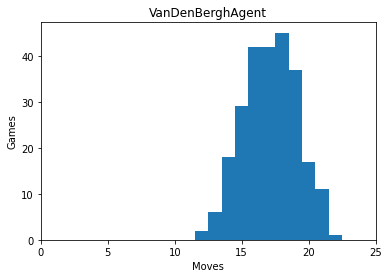

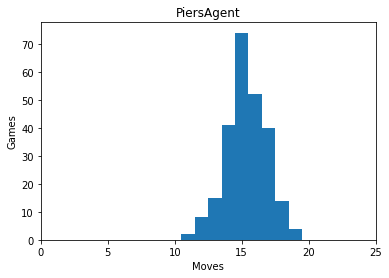

In [138]:
for k,v in experiment_dict



plot_hist(experiment_dict["VanDenBerghAgent vs VanDenBerghAgent"].game_df["score"],xlabel="Moves",ylabel="Games", title="VanDenBerghAgent", xlim=(0,25))
plot_hist(experiment_dict["OuterAgent vs OuterAgent"].game_df["score"],xlabel="Moves",ylabel="Games", title="PiersAgent", xlim=(0,25))

In [131]:
sum(experiment_dict["OuterAgent vs OuterAgent"].game_df["score"] == 13)

15